The point of this first section is to make a histogram of tweet frequency from 8-830pm for the sep 16 GOP debate. 
<br />
Code is presented for both Spark SQL and Pandas.

In [1]:
data_path = 'data/20*.gz'
path = ''

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# get rid of gridlines 
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)

import json
from dateutil import parser, tz
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import utils
import re
path                 = '/Users/andrew/git-local/'
party_of_debate     = 'democrat'
search_json_fname     = path+'search-terms.json'
search_terms         = []

# Load nested JSON of search terms
jdata = utils.get_search_json(search_json_fname)

# Collect all search terms in JSON into search_terms list
search_terms = utils.pool_search_terms(jdata)
p = '|(\s|#|@)'.join(search_terms)


from pyspark.sql import SQLContext, Row
import pyspark.sql.functions as sqlfunc

In [4]:
jdata

{u'candidates': {u'democrat': {u'clinton': [u'clinton',
    u"clinton's",
    u'hillary',
    u"hillary's",
    u'hillaryclinton',
    u'readyforhillary',
    u'Hillary2016'],
   u'omalley': [u'omalley', u"o'malley", u'OMalley2016', u'martinomalley'],
   u'sanders': [u'sanders',
    u"sanders'",
    u"sanders's",
    u'bernie',
    u"bernie's",
    u'feelthebern',
    u'BernieSanders2016',
    u'Sanders2016']},
  u'gop': {u'bush': [u'bush',
    u"bush's",
    u'jeb',
    u"jeb's",
    u'jebbush',
    u'jebcanfixit',
    u'AllinForJeb'],
   u'carson': [u'carson',
    u"carson's",
    u'bencarson',
    u'BC2DC16',
    u'ImWithBen',
    u'Carson2016'],
   u'cruz': [u'cruz', u"cruz's", u'tedcruz', u'ATimeForTruth', u'CruzCrew'],
   u'fiorina': [u'fiorina', u"fiorina's", u'carlyfiorina', u'Carly2016'],
   u'kaisch': [u'kaisch', u"kaisch's", u'johnkaisch'],
   u'rand': [u'rand', u"rand's", u'randpaul', u'StandWithRand'],
   u'rubio': [u'rubio', u"rubio's", u'marcorubio', u'TeamMarco'],
   u'

In [2]:
def make_json(tweet):
    ''' Get stringified JSOn from Kafka, attempt to convert to JSON '''
    try:
        return json.loads(tweet.decode('utf-8'))
    except:
        return "error"+str(tweet.decode('utf-8'))

def filter_tweets(item,pattern):
    ''' Filters out the tweets we do not want.  Filters include:
            * No retweets 
            * No geolocation or location field (do we really care about this?)
            * English language only
            * No tweets with links
                - We need to check both entities and media fields for this (is that true?)
    '''
    return (('delete' not in item.keys()) and
            ('retweeted_status' not in item.keys())                           and 
            (item['lang']=='en')                       and
            (len(item['entities']['urls'])==0)                   and
            ('media' not in item['entities'].keys()) and
            (re.search(pattern,item['text'],re.I) is not None)
           )

def get_relevant_fields(item):
    ''' Reduce the full set of metadata down to only those we care about, including:
            * timestamp
            * username
            * text of tweet 
            * hashtags
            * geotag coordinates (if any)
            * location (user-defined in profile, not necessarily current location)
    '''
    return (item['id'], 
            {"timestamp":  item['created_at'],
             "username":    item['user']['screen_name'],
             "text":        item['text'],
             "hashtags":    [el['text'] for el in item['entities']['hashtags']],
             "geotag":    item['geo'],
             "user_loc":    item['user']['location']
            }
           )

def update_tz(d,dtype):
    
    def convert_timezone(item):
        from_zone = tz.gettz('UTC')
        to_zone = tz.gettz('America/New_York')
        dt = parser.parse(item['timestamp'])
        utc = dt.replace(tzinfo=from_zone)
        return utc.astimezone(to_zone)
    
    if dtype == "sql":
        return Row(id=d[0], time=convert_timezone(d[1]))
    elif dtype == "pandas":
        return convert_timezone(d[1])

In [3]:
n_parts  = 10
rdd      = sc.textFile(data_path).repartition(n_parts).cache() # partitionBy fails here, need to use repartition()
filtered = (rdd.map(make_json)
               .filter( lambda x: filter_tweets(x,p) )
               .map( get_relevant_fields, preservesPartitioning=True )
            )

Below we demonstrate the syntax differences between using Spark SQL Data Frames and Pandas Data Frames

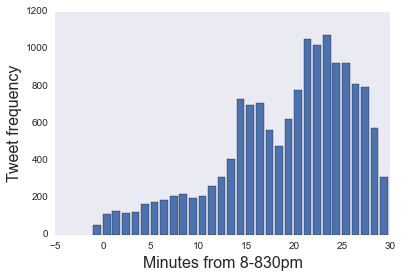

In [8]:
# SparkSQL 

data = filtered.map( lambda x: update_tz(x,'sql'), preservesPartitioning=True )
df = sqlContext.createDataFrame(data).cache()
counts = df.groupby(sqlfunc.minute("time")).count().collect()
minutes,cts = zip(*counts)
minutes = [m if m<59 else -1 for m in minutes] # for some reason 7:59 tweets get included in the 8-815 range

plt.bar(minutes,cts)
plt.xlabel("Minutes from 8-830pm", fontsize=16)
_=plt.ylabel("Tweet frequency", fontsize=16)

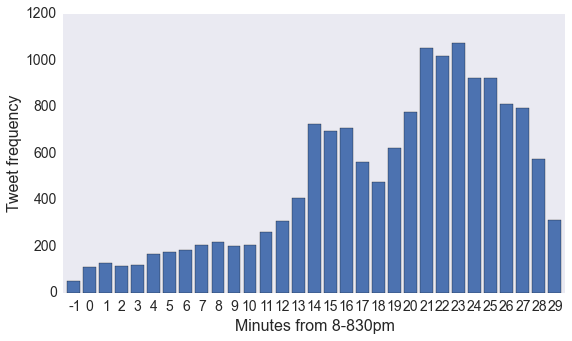

In [16]:
# Pandas

data   = filtered.map( lambda x: update_tz(x,'pandas'), preservesPartitioning=True )
df     = pd.DataFrame(data.collect(),columns=['time'])
counts = df.time.groupby(df.time.dt.minute).count()

np.put( counts.index.values, np.where(counts.index==59)[0],-1) # for some reason 7:59 tweets included in 8-815 range
ax = counts.sort_index().plot(kind='bar',
                              figsize=(9,5),
                              width=.8,
                              fontsize=14,
                              rot=0)
ax.set_ylabel("Tweet frequency",fontsize=16)
_=ax.set_xlabel("Minutes from 8-830pm",fontsize=16)

In this next section we create indicator variables for each candidate.  A mention in the tweet text or hashtag list of any of the search terms associated with each candidate will mark a 1 for that candidate's indicator. Thinking in terms of data frames here. We'll start from the 'filtered' RDD.

In [65]:
j

['{"general":["gopdebate","cnndebate","cnbcdebate","foxbusinessdebate","republicandebate","democraticdebate","candidates"],"candidates":{"democrat":{"clinton":["clinton","clinton\'s","hillary","hillary\'s","hillaryclinton","readyforhillary","Hillary2016"],"sanders":["sanders","sanders\'","sanders\'s","bernie","bernie\'s","feelthebern","BernieSanders2016","Sanders2016"],"omalley":["omalley","o\'malley","OMalley2016","martinomalley"]},"gop":{"bush":["bush","bush\'s","jeb","jeb\'s","jebbush","jebcanfixit","AllinForJeb"],"carson":["carson","carson\'s","bencarson","BC2DC16","ImWithBen","Carson2016"],"cruz":["cruz","cruz\'s","tedcruz","ATimeForTruth","CruzCrew"],"fiorina":["fiorina","fiorina\'s","carlyfiorina","Carly2016"],"kaisch":["kaisch","kaisch\'s","johnkaisch"],"rand":["rand","rand\'s","randpaul","StandWithRand"],"rubio":["rubio","rubio\'s","marcorubio","TeamMarco"],"trump":["trump","trump\'s","donaldtrump","DonaldTrumpforPresident","Trump2016","makeamericagreatagain","realdonaldtrump"

In [68]:
import json 
f = open('search-terms.json','r')
j = f.readlines()
f.close()
searchj = json.loads(j[0])

In [70]:
all_terms = []
def get_vals(j):
    ''' Short recursive routine to pull out all search terms in search-terms.json '''
    if isinstance(j,dict):
        for j2 in j.values():
            get_vals(j2)
    else:
        all_terms.extend( j )
        
get_vals(searchj)

[u'sanders', u"sanders'", u"sanders's", u'bernie', u"bernie's", u'feelthebern', u'BernieSanders2016', u'Sanders2016', u'clinton', u"clinton's", u'hillary', u"hillary's", u'hillaryclinton', u'readyforhillary', u'Hillary2016', u'omalley', u"o'malley", u'OMalley2016', u'martinomalley', u'rand', u"rand's", u'randpaul', u'StandWithRand', u'trump', u"trump's", u'donaldtrump', u'DonaldTrumpforPresident', u'Trump2016', u'makeamericagreatagain', u'realdonaldtrump', u'cruz', u"cruz's", u'tedcruz', u'ATimeForTruth', u'CruzCrew', u'rubio', u"rubio's", u'marcorubio', u'TeamMarco', u'carson', u"carson's", u'bencarson', u'BC2DC16', u'ImWithBen', u'Carson2016', u'fiorina', u"fiorina's", u'carlyfiorina', u'Carly2016', u'bush', u"bush's", u'jeb', u"jeb's", u'jebbush', u'jebcanfixit', u'AllinForJeb', u'kaisch', u"kaisch's", u'johnkaisch', u'gopdebate', u'cnndebate', u'cnbcdebate', u'foxbusinessdebate', u'republicandebate', u'democraticdebate', u'candidates']


In [46]:
party_of_debate = 'democrat'
search_json_fname = 'search-terms.json'
search_json = sqlContext.read.json(search_json_fname)
candidates = j.select(j.candidates[party_of_debate]).flatMap(lambda x: x).collect()
for c in cands:
    print c.asDict().items()

[('omalley', [u'omalley', u"o'malley", u'OMalley2016', u'martinomalley']), ('clinton', [u'clinton', u"clinton's", u'hillary', u"hillary's", u'hillaryclinton', u'readyforhillary', u'Hillary2016']), ('sanders', [u'sanders', u"sanders'", u"sanders's", u'bernie', u"bernie's", u'feelthebern', u'BernieSanders2016', u'Sanders2016'])]


In [4]:
st = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('search-terms.csv')
sqlContext.registerDataFrameAsTable(st,'term_table')


Py4JJavaError: An error occurred while calling o28.load.
: java.lang.ClassNotFoundException: Failed to load class for data source: com.databricks.spark.csv.
	at org.apache.spark.sql.execution.datasources.ResolvedDataSource$.lookupDataSource(ResolvedDataSource.scala:67)
	at org.apache.spark.sql.execution.datasources.ResolvedDataSource$.apply(ResolvedDataSource.scala:87)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:114)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:104)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.ClassNotFoundException: com.databricks.spark.csv.DefaultSource
	at java.net.URLClassLoader.findClass(URLClassLoader.java:381)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:424)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:357)
	at org.apache.spark.sql.execution.datasources.ResolvedDataSource$$anonfun$4$$anonfun$apply$1.apply(ResolvedDataSource.scala:60)
	at org.apache.spark.sql.execution.datasources.ResolvedDataSource$$anonfun$4$$anonfun$apply$1.apply(ResolvedDataSource.scala:60)
	at scala.util.Try$.apply(Try.scala:161)
	at org.apache.spark.sql.execution.datasources.ResolvedDataSource$$anonfun$4.apply(ResolvedDataSource.scala:60)
	at org.apache.spark.sql.execution.datasources.ResolvedDataSource$$anonfun$4.apply(ResolvedDataSource.scala:60)
	at scala.util.Try.orElse(Try.scala:82)
	at org.apache.spark.sql.execution.datasources.ResolvedDataSource$.lookupDataSource(ResolvedDataSource.scala:60)
	... 14 more


In [ ]:
debate_party = "gop"
cdf = sqlContext.sql('SELECT candidates.{} FROM table'.format(debate_party))

In [167]:
cdf.printSchema()

root
 |-- gop: struct (nullable = true)
 |    |-- bush: struct (nullable = true)
 |    |    |-- terms: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |-- carson: struct (nullable = true)
 |    |    |-- terms: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |-- cruz: struct (nullable = true)
 |    |    |-- terms: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |-- fiorina: struct (nullable = true)
 |    |    |-- terms: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |-- kaisch: struct (nullable = true)
 |    |    |-- terms: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |-- rand: struct (nullable = true)
 |    |    |-- terms: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |-- rubio: struct (nullable = true)
 |    |    |-- terms: array (nullable = t

In [178]:
cdf.select(cdf.gop).columns

['gop']

In [79]:
df4.printSchema()

root

